In [1]:
import MGTomo.model as mgmodel
import numpy as np
import astra
import MGTomo.tomoprojection as mgproj
from MGTomo.utils import myexp, mylog, mydiv
import MGTomo.Yfunctions as fcts
from scipy import interpolate
from skimage.data import shepp_logan_phantom
from skimage.transform import resize

import torch
from torch.func import grad

In [2]:
torch.autograd.set_detect_anomaly(True)

In [3]:
max_levels = 1
maxIter = [5,5]

In [4]:
N = 63
# load image
x_orig = shepp_logan_phantom()
x_orig = resize(x_orig, (N,N), anti_aliasing = False)

x_torch = torch.tensor(x_orig, requires_grad = True)

In [5]:
model = mgmodel.astra_model(N,{'mode' : 'line', 'num_angles' : 50, 'level_decrease' : 1})
fine_dim = model.dim
A = [mgproj.TomoTorch(model.proj_factory(fine_dim))]
b = [A[0](x_torch)]
level = {int(np.sqrt(A[0].shape[1])): 0}

for i in range(1,max_levels+1):
    coarse_dim = model.reduce_dim(fine_dim)
    A.append(mgproj.TomoTorch(model.proj_factory(coarse_dim)))
    b.append(torch.from_numpy(model.reduce_rhs(b[-1].detach().numpy(), fine_dim, coarse_dim)))
    level.update({int(np.sqrt(A[i].shape[1])): i})
    fine_dim=coarse_dim

In [6]:
print(level)

{63: 0, 31: 1}


In [7]:
for i in range(max_levels+1):
    assert b[i].shape[0]*b[i].shape[1] == A[i].shape[0], 'dimension mismatch'
    print(f'level {i}:', b[i].shape[0]*b[i].shape[1], A[i].shape[0], np.sqrt(A[i].shape[1]))

level 0: 3150 3150 63.0
level 1: 1550 1550 31.0


In [8]:
import matplotlib.pyplot as plt 

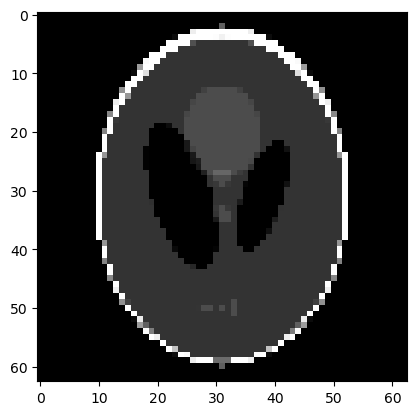

In [9]:
plt.imshow(x_orig, cmap = 'gray')

## Operators and objective definition

In [10]:
fh = lambda x: fcts.kl_distance(x, A[0], b[0])

In [11]:
def R(y):
    x = y[1:-1:2, 1:-1:2]
    return x

def bilinear_interpolation(v):
    inter = interpolate.RegularGridInterpolator((np.arange(1,2*v.shape[0],2), np.arange(1,2*v.shape[1],2)), v.detach().numpy(), method='linear', bounds_error=False, fill_value=0.0)
    xx, yy = np.meshgrid(np.arange(0,2*v.shape[0]+1), np.arange(0,2*v.shape[1]+1))
    return inter((yy,xx))

def P(x):
    return torch.from_numpy(bilinear_interpolation(x))

## Coarsening functions tester

In [12]:
def coarsen_fn(fh, x, y0, l):
    x0 = R(y0)
    x0.retain_grad()
    
    fH = lambda x: fcts.kl_distance(x, A[l], b[l])
    
    fhy0 = fh(y0)
    fhy0.backward(retain_graph = True)
    
    fHx0 = fH(x0)
    fHx0.backward(retain_graph = True)
    
    kappa = R(y0.grad) - x0.grad
    val = fH(x) + torch.sum(kappa * x)
    
    return val

In [13]:
def MLO(fh, y, l=0):
    #y.requires_grad = True
    x = R(y)
    x.retain_grad()
    y0, x0 = y, R(y)
    psi = lambda x: coarsen_fn(fh, x, y0, l+1)
    
    for i in range(maxIter[l]):
        x.retain_grad()
        x = fcts.SMART(psi, x, tau)
        
    if l < max_levels-1:
        x = MLO(psi, x, l+1)
        
    d = P(x-x0)
    #print(d)
    y = fcts.armijo_linesearch(fh, y0, d)
    #print(y.requires_grad)
    
    for i in range(maxIter[l]):
        y.retain_grad()
        y = fcts.SMART(fh, y, tau)
    
    return y

# Tests

In [14]:
tau = 1/A[0].sumnorm()

y0 = torch.ones(N, N)*0.5
y0.requires_grad = True

## Test KL-div

In [15]:
y = y0
for i in range(200):
    y.retain_grad()
    y = fcts.SMART(fh, y, tau)
print(fh(y))

tensor(0.6704, dtype=torch.float64, grad_fn=<SumBackward0>)


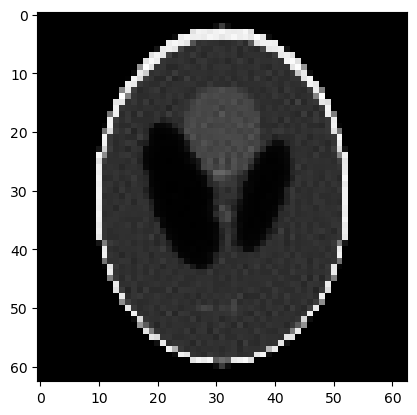

In [16]:
plt.imshow(y.detach().numpy(), cmap = 'gray')

## Test ML0
first we start with one iterate. The recursive Aufruf of MLO still has a few issues to be resolved

In [17]:
y1 = MLO(fh, y0)

In [18]:
y1

tensor([[1.6410e-10, 1.0014e-11, 1.9059e-12,  ..., 1.0725e-13, 5.6058e-13,
         4.5385e-11],
        [6.2014e-12, 2.1379e-17, 1.6139e-12,  ..., 1.9685e-13, 3.6607e-18,
         6.5854e-13],
        [1.6619e-09, 7.1751e-09, 2.0729e-10,  ..., 9.0652e-12, 5.6422e-10,
         1.1331e-10],
        ...,
        [3.5512e-13, 1.7002e-10, 3.6790e-12,  ..., 6.2444e-12, 9.3634e-11,
         3.0097e-13],
        [7.5160e-12, 1.2195e-18, 1.1276e-11,  ..., 3.9994e-11, 1.5806e-18,
         3.1938e-12],
        [1.3037e-10, 4.8635e-11, 9.1685e-12,  ..., 1.7520e-11, 7.4132e-11,
         1.3805e-10]], grad_fn=<MulBackward0>)